# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve

C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Loading Dataset

In [2]:
emp_df = pd.read_csv('Employment_Number.csv')

# Data Preprocessing

In [3]:
emp_df.shape

(384, 5)

In [4]:
emp_df.dtypes

Statistic Label    object
Day                object
NACE Sector        object
UNIT               object
VALUE               int64
dtype: object

In [5]:
emp_df.head()

,Statistic Label,Day,NACE Sector,UNIT,VALUE
0,Number of Employments,2022 June 20,Financial and insurance activities (K),Number,23
1,Number of Employments,2022 June 20,Transportation and Storage (H),Number,42
2,Number of Employments,2022 June 20,Information and communication (J),Number,62
3,Number of Employments,2022 June 20,Public Administration and Defence (O),Number,66
4,Number of Employments,2022 June 20,Education (P),Number,75


In [6]:
emp_df.isna().mean()

Statistic Label    0.0
Day                0.0
NACE Sector        0.0
UNIT               0.0
VALUE              0.0
dtype: float64

In [7]:
emp_df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
379    False
380    False
381    False
382    False
383    False
Length: 384, dtype: bool

In [8]:
emp_df.describe()

,VALUE
count,384.000000
mean,3145.791667
std,6821.106157
min,23.000000
25%,377.500000
50%,743.500000
75%,2409.500000
max,43705.000000


In [9]:
emp_df['Week'] = pd.to_datetime(emp_df['Day'])

In [10]:
emp_df.head()

,Statistic Label,Day,NACE Sector,UNIT,VALUE,Week
0,Number of Employments,2022 June 20,Financial and insurance activities (K),Number,23,2022-06-20
1,Number of Employments,2022 June 20,Transportation and Storage (H),Number,42,2022-06-20
2,Number of Employments,2022 June 20,Information and communication (J),Number,62,2022-06-20
3,Number of Employments,2022 June 20,Public Administration and Defence (O),Number,66,2022-06-20
4,Number of Employments,2022 June 20,Education (P),Number,75,2022-06-20


In [11]:
# Remove 'All NACE Economic Sectors'
emp_df = emp_df[emp_df['NACE Sector'] != 'All NACE Economic Sectors']

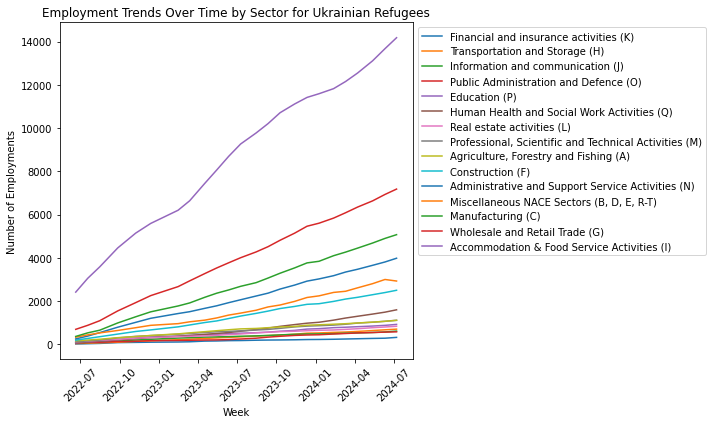

In [12]:
# Plot employment trends over time for each sector
plt.figure(figsize=(10, 6))
for sector in emp_df['NACE Sector'].unique():
    sector_data = emp_df[emp_df['NACE Sector'] == sector]
    plt.plot(sector_data['Week'], sector_data['VALUE'], label=sector)

plt.xlabel('Week')
plt.ylabel('Number of Employments')
plt.title('Employment Trends Over Time by Sector for Ukrainian Refugees')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Dominant Sectors of Employment :- Accommodation & Food Service Activities, Human Health and Social Work Activities
### Moderate Growth Sectors :- Administrative and Support Service Activities, Education, Manufacturing and Wholesale and Retail Trade 
### Slower Growing Sectors :- Information and Communication, Real Estate Activities, Financial and Insurance Activities, Public Administration and Defence, Agriculture, Forestry, and Fishing

# Correlation Analysis

In [13]:
# Create pivot table for all sectors
emp_pivot = emp_df.pivot_table(
    index='Week',
    columns='NACE Sector',
    values='VALUE'
).reset_index()

In [14]:
# Check correlation between sectors
target_sector = 'Accommodation & Food Service Activities (I)'
correlations = emp_pivot.corr()[target_sector].sort_values(ascending=False)

In [15]:
print(f"Sector Correlations with Accommodation & Food Service:{correlations}")

Sector Correlations with Accommodation & Food Service:NACE Sector
Accommodation & Food Service Activities (I)              1.000000
Agriculture, Forestry and Fishing (A)                    0.998387
Wholesale and Retail Trade (G)                           0.996223
Real estate activities (L)                               0.996165
Week                                                     0.995733
Financial and insurance activities (K)                   0.994602
Manufacturing (C)                                        0.994105
Construction (F)                                         0.994102
Information and communication (J)                        0.993504
Professional, Scientific and Technical Activities (M)    0.993500
Administrative and Support Service Activities (N)        0.993121
Transportation and Storage (H)                           0.992397
Education (P)                                            0.992330
Miscellaneous NACE Sectors (B, D, E, R-T)                0.980436
Public Adm

In [16]:
# Create feature matrix using other sectors
X = emp_pivot.drop([target_sector, 'Week'], axis=1)
y = emp_pivot[target_sector]

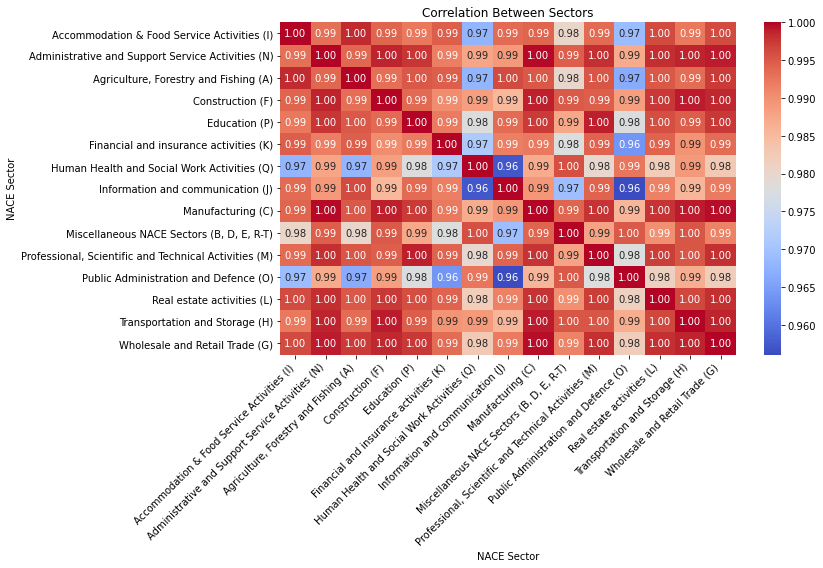

In [17]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(emp_pivot.drop('Week', axis=1).corr(), 
            annot=True, 
            cmap='coolwarm',
            fmt='.2f')
plt.title('Correlation Between Sectors')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Strong Correlations: Sectors such as Agriculture, Forestry and Fishing, Wholesale and Retail Trade, and Real Estate Activities have high positive correlations (close to 1) with Accommodation & Food Service, suggesting these sectors might experience employment trends similar to Accommodation & Food Service.

### Other Notable Correlations: Variables such as Week and Manufacturing also show strong positive correlations, indicating potential seasonality or cyclical employment patterns.

### Moderate Correlations: Sectors like Public Administration and Defence and Human Health and Social Work Activities have lower correlations, suggesting they may be less directly influenced by employment trends in Accommodation & Food Service.

# Apply Machine Learning Model

In [18]:
# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Random Forest Model

In [19]:
# Initialize model
random_forest = RandomForestRegressor(random_state=42)

In [20]:
# Train model
random_forest.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [21]:
# Make predictions on training and testing sets
y_train_pred_rf = random_forest.predict(X_train_scaled)
y_test_pred_rf = random_forest.predict(X_test_scaled)

In [22]:
# Calculate metrics for training set
rf_train_results = {
    'R2': r2_score(y_train, y_train_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_rf)),
    'MAE': mean_absolute_error(y_train, y_train_pred_rf)
}

In [23]:
print("Random Forest - Training Performance:")
for metric, value in rf_train_results.items():
    print(f"{metric}: {value:.4f}")


Random Forest - Training Performance:
R2: 0.9987
RMSE: 127.1770
MAE: 88.4311


In [24]:
rf_test_results = {
    'R2': r2_score(y_test, y_test_pred_rf),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_rf)),
    'MAE': mean_absolute_error(y_test, y_test_pred_rf)
}

In [25]:
print("Random Forest - Testing Performance:")
for metric, value in rf_test_results.items():
    print(f"{metric}: {value:.4f}")


Random Forest - Testing Performance:
R2: 0.9815
RMSE: 464.3919
MAE: 311.2900


In [26]:
# Cross-validation results
cv_scores_rf = cross_val_score(random_forest, X_train_scaled, y_train, cv=5)
print("\nRandom Forest - Cross-Validation Performance:")
print(f"CV Mean: {cv_scores_rf.mean():.4f}")
print(f"CV Std: {cv_scores_rf.std():.4f}")


Random Forest - Cross-Validation Performance:
CV Mean: 0.9866
CV Std: 0.0091


In [27]:
# Feature importance chart
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': random_forest.feature_importances_
}).sort_values('importance', ascending=False)

In [28]:
# Feature importance values
feature_importance_rf = pd.DataFrame({
    'feature': X.columns,
    'importance': random_forest.feature_importances_
}).sort_values('importance', ascending=False)
print("Random Forest - Feature Importances:")
print(feature_importance_rf)

Random Forest - Feature Importances:
                                              feature  importance
12                     Transportation and Storage (H)    0.094822
8           Miscellaneous NACE Sectors (B, D, E, R-T)    0.087288
1               Agriculture, Forestry and Fishing (A)    0.085010
7                                   Manufacturing (C)    0.084636
9   Professional, Scientific and Technical Activit...    0.081104
0   Administrative and Support Service Activities (N)    0.077206
13                     Wholesale and Retail Trade (G)    0.076432
2                                    Construction (F)    0.071920
6                   Information and communication (J)    0.070474
5         Human Health and Social Work Activities (Q)    0.067862
3                                       Education (P)    0.062121
4              Financial and insurance activities (K)    0.055917
11                         Real estate activities (L)    0.045721
10              Public Administration a

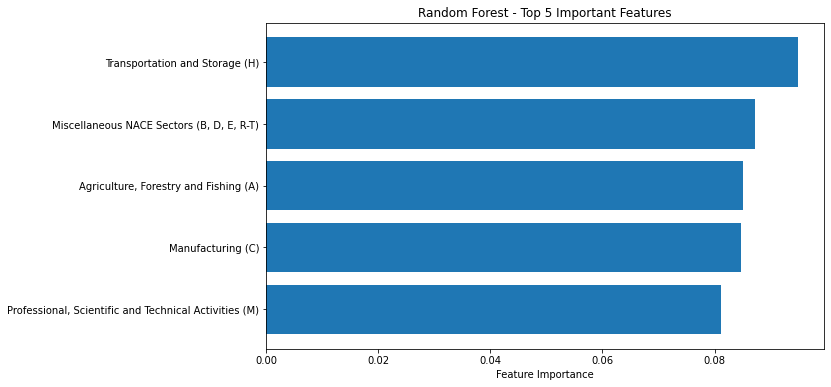

In [29]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['feature'][:5], feature_importance_rf['importance'][:5])
plt.gca().invert_yaxis()
plt.title("Random Forest - Top 5 Important Features")
plt.xlabel("Feature Importance")
plt.show()

## Gradient Boosting

In [30]:
# Initialize model
gradient_boosting = GradientBoostingRegressor(random_state=42)

In [31]:
# Train the model
gradient_boosting.fit(X_train_scaled, y_train)

GradientBoostingRegressor(random_state=42)

In [32]:
# Training results
y_train_pred_gb = gradient_boosting.predict(X_train_scaled)
gb_train_results = {
    'R2': r2_score(y_train, y_train_pred_gb),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_gb)),
    'MAE': mean_absolute_error(y_train, y_train_pred_gb)
}

In [33]:
print("\nGradient Boosting - Training Performance:")
for metric, value in gb_train_results.items():
    print(f"{metric}: {value:.4f}")


Gradient Boosting - Training Performance:
R2: 1.0000
RMSE: 0.1129
MAE: 0.0908


In [34]:
# Testing results
y_test_pred_gb = gradient_boosting.predict(X_test_scaled)
gb_test_results = {
    'R2': r2_score(y_test, y_test_pred_gb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_gb)),
    'MAE': mean_absolute_error(y_test, y_test_pred_gb)
}

In [35]:
print("\nGradient Boosting - Testing Performance:")
for metric, value in gb_test_results.items():
    print(f"{metric}: {value:.4f}")


Gradient Boosting - Testing Performance:
R2: 0.9867
RMSE: 393.2624
MAE: 332.7844


In [36]:
# Cross-validation results
cv_scores_gb = cross_val_score(gradient_boosting, X_train_scaled, y_train, cv=5)
print("\nGradient Boosting - Cross-Validation Performance:")
print(f"CV Mean: {cv_scores_gb.mean():.4f}")
print(f"CV Std: {cv_scores_gb.std():.4f}")


Gradient Boosting - Cross-Validation Performance:
CV Mean: 0.9864
CV Std: 0.0053


### Overfitting possibility detected

In [68]:
gradient_boosting = GradientBoostingRegressor(
    random_state=42,
    learning_rate=0.01,        # Lower learning rate
    n_estimators=200,          # Increase number of trees
    max_depth=3,               # Limit depth of each tree
    min_samples_split=10       # Minimum samples per split
)

In [69]:
# Train the model
gradient_boosting.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.01, min_samples_split=10,
                          n_estimators=200, random_state=42)

In [70]:
# Training results
y_train_pred_gb = gradient_boosting.predict(X_train_scaled)
gb_train_results = {
    'R2': r2_score(y_train, y_train_pred_gb),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_gb)),
    'MAE': mean_absolute_error(y_train, y_train_pred_gb)
}

In [71]:
print("Gradient Boosting - Training Performance:")
for metric, value in gb_train_results.items():
    print(f"{metric}: {value:.4f}")

Gradient Boosting - Training Performance:
R2: 0.9660
RMSE: 641.3478
MAE: 459.3796


In [72]:
# Testing results
y_test_pred_gb = gradient_boosting.predict(X_test_scaled)
gb_test_results = {
    'R2': r2_score(y_test, y_test_pred_gb),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_gb)),
    'MAE': mean_absolute_error(y_test, y_test_pred_gb)
}

In [74]:
print("Gradient Boosting - Testing Performance:")
for metric, value in gb_test_results.items():
    print(f"{metric}: {value:.4f}")

Gradient Boosting - Testing Performance:
R2: 0.9023
RMSE: 1066.6230
MAE: 704.9361


In [76]:
# Cross-validation results
cv_scores_gb = cross_val_score(gradient_boosting, X_train_scaled, y_train, cv=5)
print("Gradient Boosting - Cross-Validation Performance:")
print(f"CV Mean: {cv_scores_gb.mean():.4f}")
print(f"CV Std: {cv_scores_gb.std():.4f}")

Gradient Boosting - Cross-Validation Performance:
CV Mean: 0.9232
CV Std: 0.0470


In [77]:
# Feature importance values
feature_importance_gb = pd.DataFrame({
    'feature': X.columns,
    'importance': gradient_boosting.feature_importances_
}).sort_values('importance', ascending=False)
print("Gradient Boosting - Feature Importances:")
print(feature_importance_gb)


Gradient Boosting - Feature Importances:
                                              feature  importance
2                                    Construction (F)    0.121607
8           Miscellaneous NACE Sectors (B, D, E, R-T)    0.108536
4              Financial and insurance activities (K)    0.098552
7                                   Manufacturing (C)    0.077428
10              Public Administration and Defence (O)    0.073131
3                                       Education (P)    0.072873
6                   Information and communication (J)    0.070674
5         Human Health and Social Work Activities (Q)    0.065994
12                     Transportation and Storage (H)    0.065114
9   Professional, Scientific and Technical Activit...    0.059733
11                         Real estate activities (L)    0.050176
1               Agriculture, Forestry and Fishing (A)    0.049107
13                     Wholesale and Retail Trade (G)    0.044918
0   Administrative and Support Ser

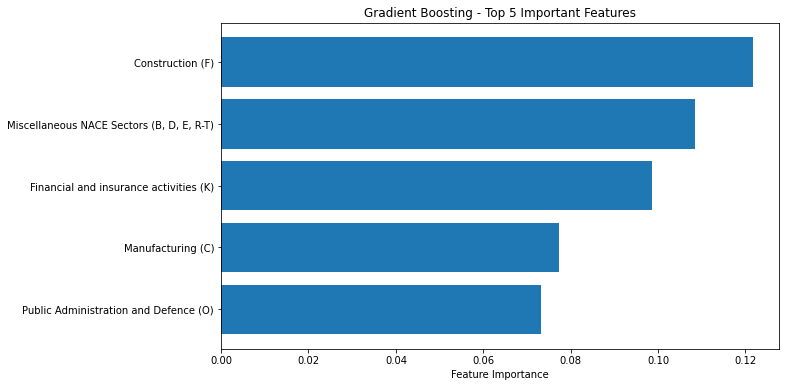

In [78]:
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_gb['feature'][:5], feature_importance_gb['importance'][:5])
plt.gca().invert_yaxis()
plt.title("Gradient Boosting - Top 5 Important Features")
plt.xlabel("Feature Importance")
plt.show()

## Neaural Network

In [39]:
# Initialize model
neural_network = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

In [40]:
# Train the model
neural_network.fit(X_train_scaled, y_train)

C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

In [41]:
# Training results
y_train_pred_nn = neural_network.predict(X_train_scaled)
nn_train_results = {
    'R2': r2_score(y_train, y_train_pred_nn),
    'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_nn)),
    'MAE': mean_absolute_error(y_train, y_train_pred_nn)
}

In [42]:
print("Neural Network - Training Performance:")
for metric, value in nn_train_results.items():
    print(f"{metric}: {value:.4f}")


Neural Network - Training Performance:
R2: 0.0530
RMSE: 3386.8845
MAE: 2827.2979


In [43]:
# Testing results
y_test_pred_nn = neural_network.predict(X_test_scaled)
nn_test_results = {
    'R2': r2_score(y_test, y_test_pred_nn),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_nn)),
    'MAE': mean_absolute_error(y_test, y_test_pred_nn)
}

In [44]:
print("Neural Network - Testing Performance:")
for metric, value in nn_test_results.items():
    print(f"{metric}: {value:.4f}")


Neural Network - Testing Performance:
R2: -0.3639
RMSE: 3985.5260
MAE: 3658.6542


In [45]:
# Cross-validation results
cv_scores_nn = cross_val_score(neural_network, X_train_scaled, y_train, cv=5)
print("Neural Network - Cross-Validation Performance:")
print(f"CV Mean: {cv_scores_nn.mean():.4f}")
print(f"CV Std: {cv_scores_nn.std():.4f}")

C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(



Neural Network - Cross-Validation Performance:
CV Mean: -0.4631
CV Std: 0.6714


C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


# Comparative Analysis

In [47]:
model_names = ['Random Forest', 'Gradient Boosting', 'Neural Network']

In [79]:
rf_r2, rf_rmse, rf_mae = 0.9815, 464.3919, 311.2900   # Random Forest metrics
gb_r2, gb_rmse, gb_mae = 0.9023, 1066.6230, 704.9361   # Gradient Boosting metrics
nn_r2, nn_rmse, nn_mae = -0.3639, 3985.5260, 3658.6542 # Neural Network metrics

In [80]:
# Define metrics for each model
r2_values = [rf_r2, gb_r2, nn_r2]
rmse_values = [rf_rmse, gb_rmse, nn_rmse]
mae_values = [rf_mae, gb_mae, nn_mae]

In [81]:
metrics = ['R2', 'RMSE', 'MAE']

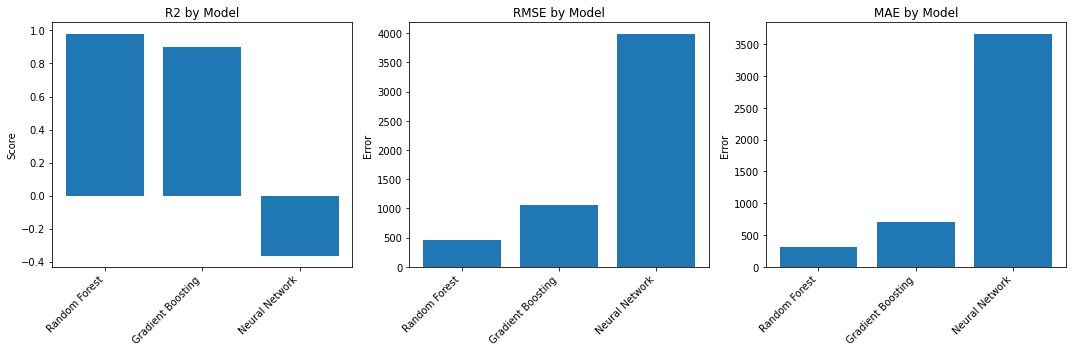

In [82]:
metrics = ['R2', 'RMSE', 'MAE']
values_list = [r2_values, rmse_values, mae_values]

plt.figure(figsize=(15, 5))
for i, (metric, values) in enumerate(zip(metrics, values_list)):
    plt.subplot(1, 3, i+1)
    plt.bar(model_names, values)
    plt.title(f'{metric} by Model')
    plt.xticks(rotation=45, ha='right')
    
    if metric != 'R2':
        plt.ylabel('Error')
    else:
        plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [83]:
r2_scores = {
    'Random Forest': rf_r2,
    'Gradient Boosting': gb_r2,
    'Neural Network': nn_r2
}

In [84]:
# Find the best model based on R2 score
best_model_name = max(r2_scores, key=r2_scores.get)

In [85]:
# Select the best model based on the name
if best_model_name == 'Random Forest':
    best_model = random_forest
elif best_model_name == 'Gradient Boosting':
    best_model = gradient_boosting
elif best_model_name == 'Neural Network':
    best_model = neural_network


In [86]:
# Train the best model (assuming it hasn't been trained yet)
best_model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [87]:
# Make predictions with the best model
y_pred_best = best_model.predict(X_test_scaled)


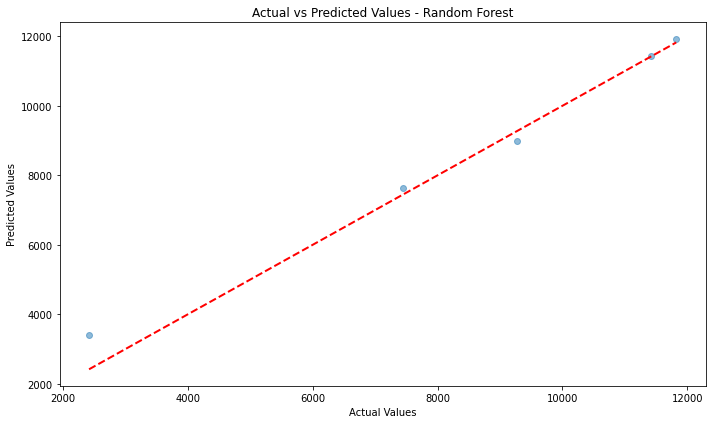

In [88]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title(f'Actual vs Predicted Values - {best_model_name}')
plt.tight_layout()
plt.show()

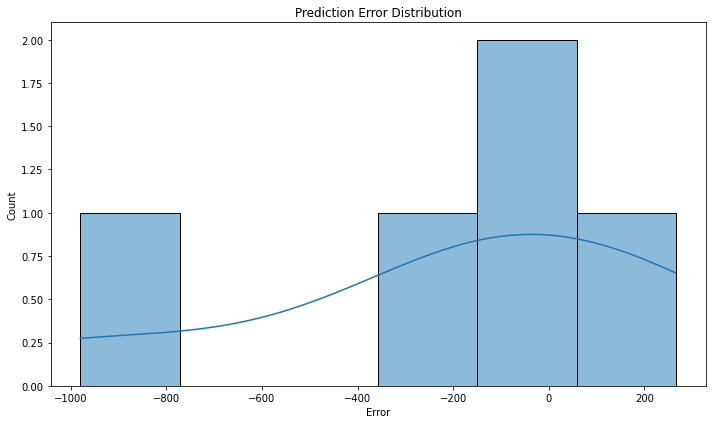

In [89]:
# Plot error distribution
plt.figure(figsize=(10, 6))
errors = y_test - y_pred_best
sns.histplot(errors, kde=True)
plt.title('Prediction Error Distribution')
plt.xlabel('Error')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [90]:
# Dictionary to store models and names
models = {
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting,
    'Neural Network': neural_network
}


Random Forest - Cross-Validation Performance:
CV Mean: 0.9866
CV Std: 0.0091


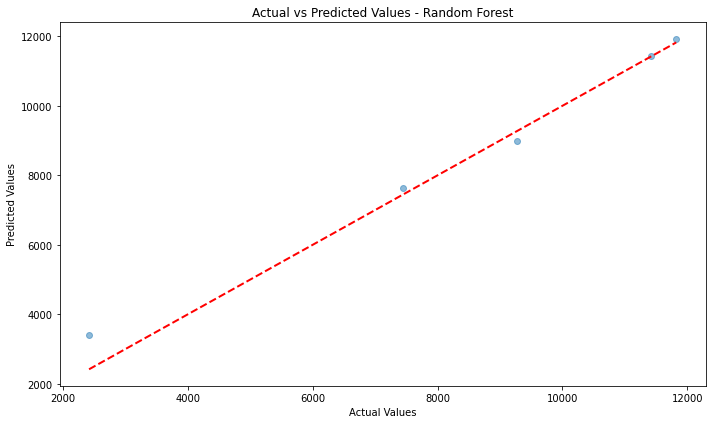


Gradient Boosting - Cross-Validation Performance:
CV Mean: 0.9232
CV Std: 0.0470


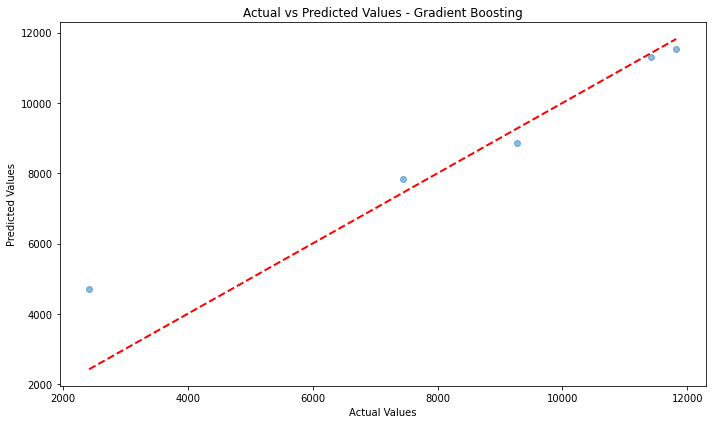

C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dikshant Bhosal


Neural Network - Cross-Validation Performance:
CV Mean: -0.4631
CV Std: 0.6714


C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


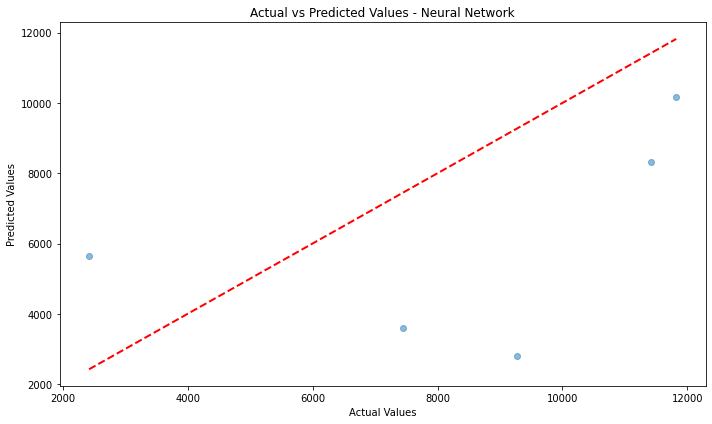

In [91]:
# Loop through each model, train, predict, and plot
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Cross-validation scores
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f"\n{model_name} - Cross-Validation Performance:")
    print(f"CV Mean: {cv_scores.mean():.4f}")
    print(f"CV Std: {cv_scores.std():.4f}")
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)

    # Plot predictions vs actual values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values - {model_name}')
    plt.tight_layout()
    plt.show()

# Hyperparameter Tuning

In [92]:
from sklearn.model_selection import GridSearchCV

In [93]:
# Initialize each model
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
nn = MLPRegressor(random_state=42)

# Define parameter grids
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

nn_param_grid = {
    'hidden_layer_sizes': [(50, 50), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000]
}

# Set up GridSearchCV for each model
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
gb_grid_search = GridSearchCV(estimator=gb, param_grid=gb_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
nn_grid_search = GridSearchCV(estimator=nn, param_grid=nn_param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)

# Fit each model
print("Tuning Random Forest...")
rf_grid_search.fit(X_train_scaled, y_train)
print("Tuning Gradient Boosting...")
gb_grid_search.fit(X_train_scaled, y_train)
print("Tuning Neural Network...")
nn_grid_search.fit(X_train_scaled, y_train)

# Collect the best estimators and their scores
best_models = {
    "Random Forest": rf_grid_search.best_estimator_,
    "Gradient Boosting": gb_grid_search.best_estimator_,
    "Neural Network": nn_grid_search.best_estimator_
}

best_params = {
    "Random Forest": rf_grid_search.best_params_,
    "Gradient Boosting": gb_grid_search.best_params_,
    "Neural Network": nn_grid_search.best_params_
}

cv_scores = {
    "Random Forest": rf_grid_search.best_score_,
    "Gradient Boosting": gb_grid_search.best_score_,
    "Neural Network": nn_grid_search.best_score_
}

# Print best parameters and cross-validation scores
print("\nBest Parameters and CV Scores:")
for model_name, params in best_params.items():
    print(f"\n{model_name} - Best Parameters: {params}")
    print(f"{model_name} - Best CV R2 Score: {cv_scores[model_name]:.4f}")

# Evaluate each model on the test set
print("\nTest Scores for Best Models:")
for model_name, model in best_models.items():
    test_r2 = model.score(X_test_scaled, y_test)
    print(f"{model_name} - Test R2 Score: {test_r2:.4f}")

Tuning Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Tuning Gradient Boosting...
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Tuning Neural Network...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 753, in fit
    r


Best Parameters and CV Scores:

Random Forest - Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest - Best CV R2 Score: 0.9878

Gradient Boosting - Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Gradient Boosting - Best CV R2 Score: 0.9864

Neural Network - Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'sgd'}
Neural Network - Best CV R2 Score: 0.8314

Test Scores for Best Models:
Random Forest - Test R2 Score: 0.9829
Gradient Boosting - Test R2 Score: 0.9867
Neural Network - Test R2 Score: 0.6673


C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [149]:
y_pred_rf = rf_grid_search.best_estimator_.predict(X_test_scaled)
y_pred_gb = gb_grid_search.best_estimator_.predict(X_test_scaled)
y_pred_nn = nn_grid_search.best_estimator_.predict(X_test_scaled)

# Calculate RMSE and MAE for Random Forest
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rf_mae = mean_absolute_error(y_test, y_pred_rf)

# Calculate RMSE and MAE for Gradient Boosting
gb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gb))
gb_mae = mean_absolute_error(y_test, y_pred_gb)

# Calculate RMSE and MAE for Neural Network
nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))
nn_mae = mean_absolute_error(y_test, y_pred_nn)

# Print results
print("RMSE and MAE for Best Models:")
print(f"Random Forest - RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}")
print(f"Gradient Boosting - RMSE: {gb_rmse:.4f}, MAE: {gb_mae:.4f}")
print(f"Neural Network - RMSE: {nn_rmse:.4f}, MAE: {nn_mae:.4f}")

RMSE and MAE for Best Models:
Random Forest - RMSE: 446.6000, MAE: 283.0390
Gradient Boosting - RMSE: 393.2624, MAE: 332.7844
Neural Network - RMSE: 1968.2931, MAE: 1527.9727


### After tuning all the three models Gradient Boosting Model outperformed other models

## Feature Importance Analysis of Gradient Boosting and Random Forest

In [97]:

gb_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': gb_grid_search.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

In [105]:
print(gb_feature_importances)

                                              Feature  Importance
7                                   Manufacturing (C)    0.204069
6                   Information and communication (J)    0.186781
3                                       Education (P)    0.123934
4              Financial and insurance activities (K)    0.116028
10              Public Administration and Defence (O)    0.108722
2                                    Construction (F)    0.089981
8           Miscellaneous NACE Sectors (B, D, E, R-T)    0.056742
0   Administrative and Support Service Activities (N)    0.036062
5         Human Health and Social Work Activities (Q)    0.020518
12                     Transportation and Storage (H)    0.019942


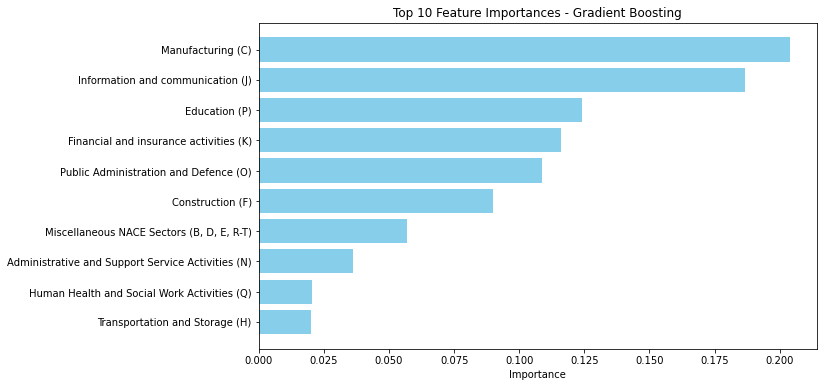

In [98]:
plt.figure(figsize=(10, 6))
plt.barh(gb_feature_importances['Feature'], gb_feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - Gradient Boosting")
plt.xlabel("Importance")
plt.show()

In [101]:
rf_feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_grid_search.best_estimator_.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

In [106]:
print(rf_feature_importances)

                                              Feature  Importance
12                     Transportation and Storage (H)    0.102648
13                     Wholesale and Retail Trade (G)    0.081341
2                                    Construction (F)    0.081166
1               Agriculture, Forestry and Fishing (A)    0.079329
7                                   Manufacturing (C)    0.078852
0   Administrative and Support Service Activities (N)    0.070488
9   Professional, Scientific and Technical Activit...    0.070341
8           Miscellaneous NACE Sectors (B, D, E, R-T)    0.066811
5         Human Health and Social Work Activities (Q)    0.066405
11                         Real estate activities (L)    0.065853


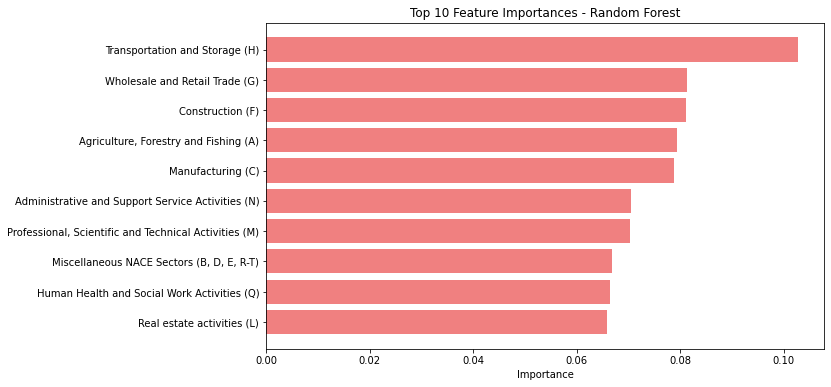

In [102]:
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importances['Feature'], rf_feature_importances['Importance'], color='lightcoral')
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Importance")
plt.show()

# Models Comparative Analysis

In [116]:
rf_r2, rf_rmse, rf_mae = 0.9829, 446.600, 283.0300   # Random Forest metrics
gb_r2, gb_rmse, gb_mae = 0.9867, 393.2624, 332.7844   # Gradient Boosting metrics
nn_r2, nn_rmse, nn_mae = 0.6673, 1968.2931, 1527.9727 # Neural Network metrics

In [117]:
model_names = ['Random Forest', 'Gradient Boosting', 'Neural Network']

In [118]:
# Define metrics for each model
r2_values = [rf_r2, gb_r2, nn_r2]
rmse_values = [rf_rmse, gb_rmse, nn_rmse]
mae_values = [rf_mae, gb_mae, nn_mae]

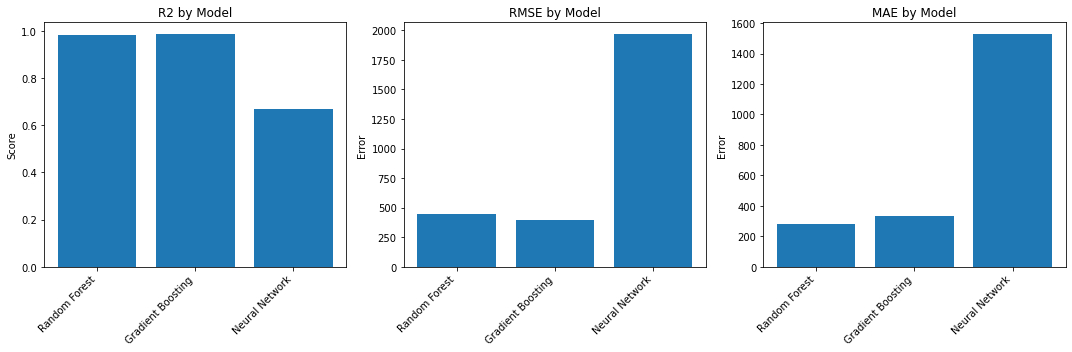

In [119]:
metrics = ['R2', 'RMSE', 'MAE']
values_list = [r2_values, rmse_values, mae_values]

plt.figure(figsize=(15, 5))
for i, (metric, values) in enumerate(zip(metrics, values_list)):
    plt.subplot(1, 3, i+1)
    plt.bar(model_names, values)
    plt.title(f'{metric} by Model')
    plt.xticks(rotation=45, ha='right')
    
    if metric != 'R2':
        plt.ylabel('Error')
    else:
        plt.ylabel('Score')

plt.tight_layout()
plt.show()

In [120]:
r2_scores = {
    'Random Forest': rf_r2,
    'Gradient Boosting': gb_r2,
    'Neural Network': nn_r2
}

In [121]:
# Find the best model based on R2 score
best_model_name = max(r2_scores, key=r2_scores.get)

# Select the best model based on the name
if best_model_name == 'Random Forest':
    best_model = random_forest
elif best_model_name == 'Gradient Boosting':
    best_model = gradient_boosting
elif best_model_name == 'Neural Network':
    best_model = neural_network

# Train the best model (assuming it hasn't been trained yet)
best_model.fit(X_train_scaled, y_train)

GradientBoostingRegressor(learning_rate=0.01, min_samples_split=10,
                          n_estimators=200, random_state=42)

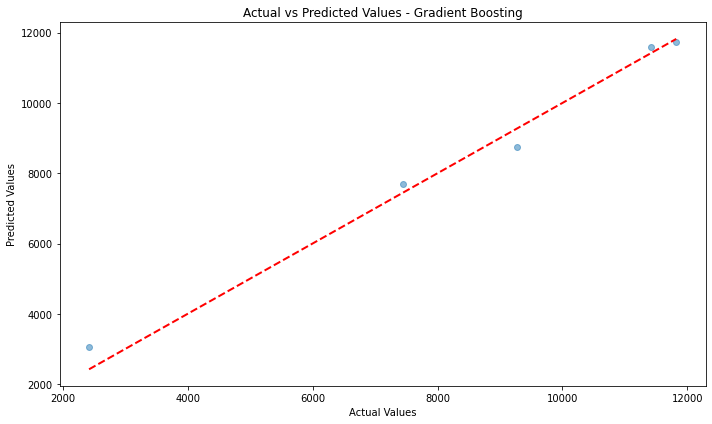

In [123]:
# Predict with the best Gradient Boosting model
y_pred_gb = gb_grid_search.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Gradient Boosting')
plt.tight_layout()
plt.show()

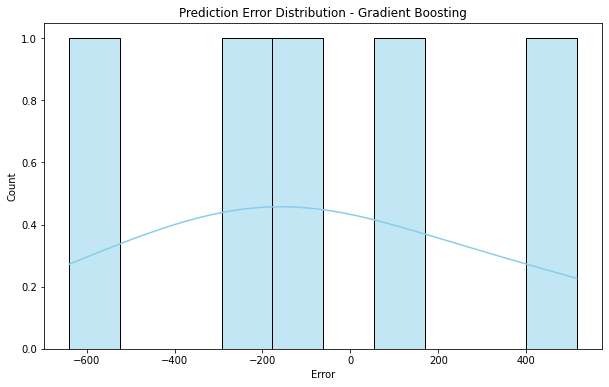

In [128]:
# Calculate errors for Gradient Boosting
errors_gb = y_test - y_pred_gb

plt.figure(figsize=(10, 6))
sns.histplot(errors_gb, kde=True, bins=10, color='skyblue')
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Prediction Error Distribution - Gradient Boosting")
plt.show()

In [129]:
y_pred_rf = rf_grid_search.best_estimator_.predict(X_test_scaled)

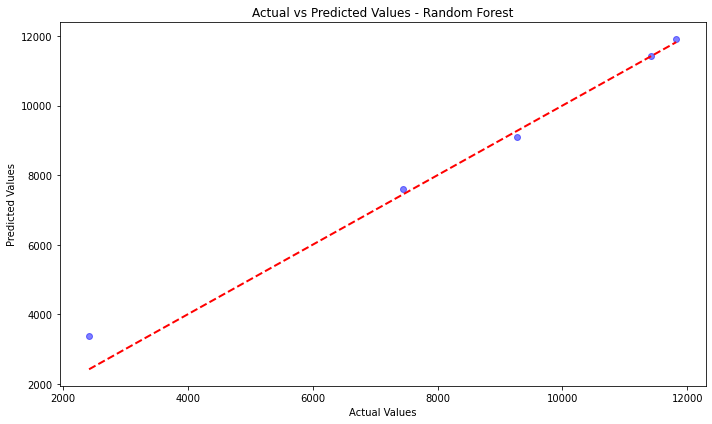

In [131]:
# Actual vs Predicted for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Random Forest')
plt.tight_layout()
plt.show()

In [135]:
errors_rf = y_test - y_pred_rf

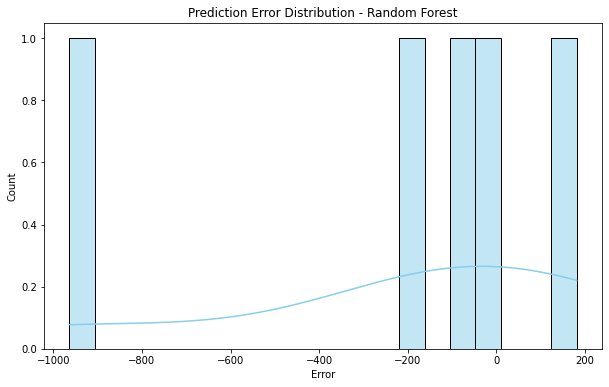

In [138]:
plt.figure(figsize=(10, 6))
sns.histplot(errors_rf, kde=True, bins=20, color='skyblue')
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Prediction Error Distribution - Random Forest")
plt.show()

In [132]:
y_pred_nn = nn_grid_search.best_estimator_.predict(X_test_scaled)

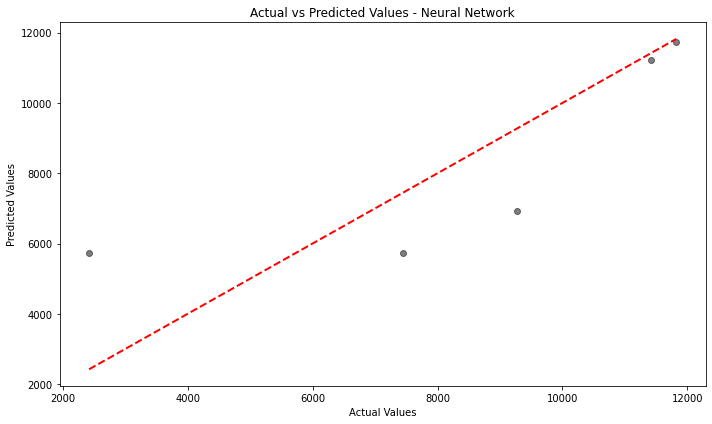

In [134]:
# Actual vs Predicted for Neural Network
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_nn, alpha=0.5, color='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values - Neural Network')
plt.tight_layout()
plt.show()

In [139]:
errors_nn = y_test - y_pred_nn

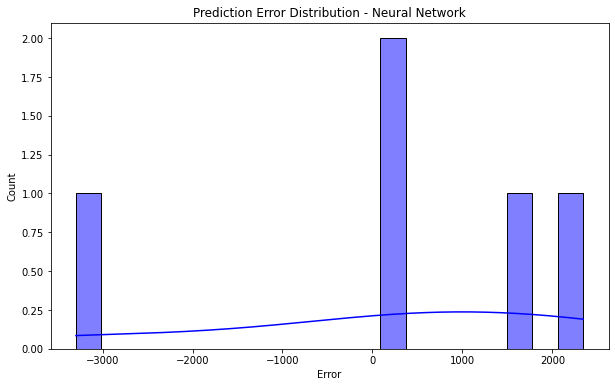

In [141]:
plt.figure(figsize=(10, 6))
sns.histplot(errors_nn, kde=True, bins=20, color='blue')
plt.xlabel("Error")
plt.ylabel("Count")
plt.title("Prediction Error Distribution - Neural Network")
plt.show()

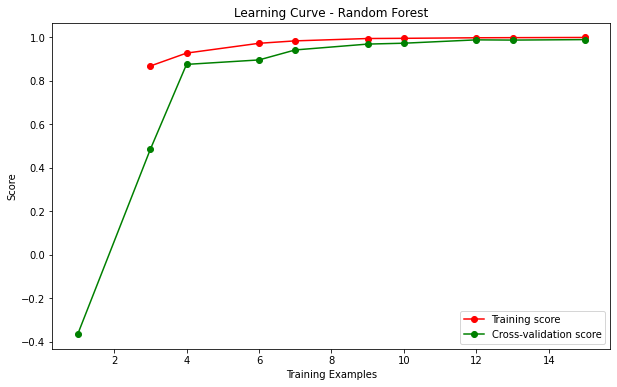

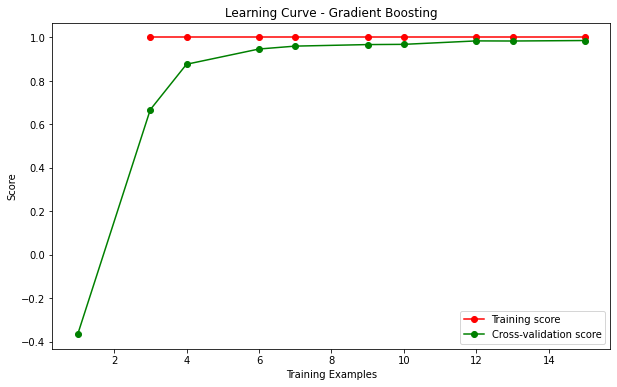

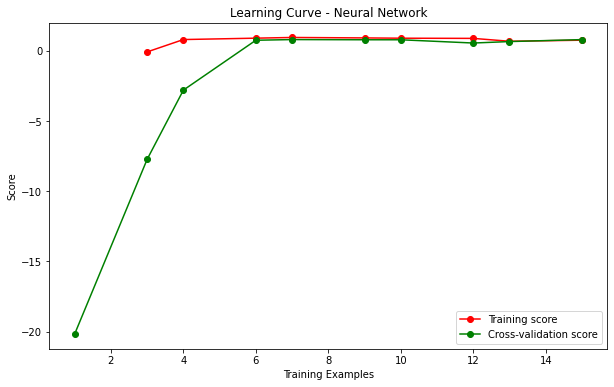

In [147]:


# Define the best models based on the results of GridSearchCV
rf_best = rf_grid_search.best_estimator_
gb_best = gb_grid_search.best_estimator_
nn_best = nn_grid_search.best_estimator_

# Function to plot learning curve
def plot_learning_curve(model, model_name):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(f"Learning Curve - {model_name}")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

# Plot learning curves for each model
plot_learning_curve(rf_best, "Random Forest")
plot_learning_curve(gb_best, "Gradient Boosting")
plot_learning_curve(nn_best, "Neural Network")


In [148]:
# Cross-validation with MAE scoring for each model
rf_mae_scores = cross_val_score(rf_best, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
gb_mae_scores = cross_val_score(gb_best, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
nn_mae_scores = cross_val_score(nn_best, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')

print(f"Random Forest - CV MAE: {-np.mean(rf_mae_scores):.4f}")
print(f"Gradient Boosting - CV MAE: {-np.mean(gb_mae_scores):.4f}")
print(f"Neural Network - CV MAE: {-np.mean(nn_mae_scores):.4f}")

C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Random Forest - CV MAE: 252.2537
Gradient Boosting - CV MAE: 315.8328
Neural Network - CV MAE: 1083.6965


C:\Users\Dikshant Bhosale\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
